In [1]:
#IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from joblib import dump, load
import pickle
from scipy.stats import randint
from imblearn.over_sampling import RandomOverSampler
import os

In [2]:
#df without others gens

df = pd.read_csv(r'C:\Users\teka_\DATA SCIENCE\Concordia-Bootcamps\FINAL PROJECT\Final\df_wo_othersGens.csv')
df

,snpID,class,chromosome,position,most_severe_consequence,GeneID,sourceId,protein_class_name,protein_class,Disease Class,Category,Gene/Protein Symbol
0,rs1000256867,snv,17,7673550,missense variant,7157,VEP,Transcription factor,DTO_05007542,cervical intraepithelial neoplasia; papillomav...,cancer,TP53
1,rs1000256867,snv,17,7673550,missense variant,7157,VEP,Transcription factor,DTO_05007542,"carcinoma, squamous cell; esophageal neoplasms...",cancer,TP53
2,rs1000256867,snv,17,7673550,missense variant,7157,VEP,Transcription factor,DTO_05007542,duodenal ulcer; helicobacter infections; stoma...,cancer,TP53
3,rs1000256867,snv,17,7673550,missense variant,7157,VEP,Transcription factor,DTO_05007542,oral lichen planus,infection,TP53
4,rs1000256867,snv,17,7673550,missense variant,7157,VEP,Transcription factor,DTO_05007542,kaposi's sarcoma,cancer,TP53
...,...,...,...,...,...,...,...,...,...,...,...,...
535090,rs967624732,snv,17,43097269,missense variant,672,VEP,Enzyme,DTO_05007624,"breast neoplasms; cell transformation, neoplas...",cancer,BRCA1
535091,rs967624732,snv,17,43097269,missense variant,672,VEP,Enzyme,DTO_05007624,"breast cancer, male",cancer,BRCA1
535092,rs967624732,snv,17,43097269,missense variant,672,VEP,Enzyme,DTO_05007624,breast neoplasms; mammary neoplasms; neoplasms...,cancer,BRCA1
535093,rs967624732,snv,17,43097269,missense variant,672,VEP,Enzyme,DTO_05007624,ovarian diseases,reproduction,BRCA1


# RANDOM FOREST

Features: Class, Chromosome, Position, Most Serious Consequence, Category

In [3]:
#prep-processing function


def preprocess_data(df, frac=1):
    # Step 1: Stratified Sampling
    def stratified_sample(df, frac):
        df_sample = df.groupby('Gene/Protein Symbol', group_keys=False).apply(lambda x: x.sample(frac=frac))
        return df_sample
    
    df_sampled = stratified_sample(df, frac)

    # Step 2: Encoding the Data
    df_encoded = pd.get_dummies(df_sampled, columns=['class', 'most_severe_consequence', 'Category'], drop_first=True)
    label_encoder = LabelEncoder()
    df_encoded['Gene/Protein Symbol'] = label_encoder.fit_transform(df_encoded['Gene/Protein Symbol'])
    dump(label_encoder, 'label_encoder.joblib')

    # Mapping classes
    label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
    for original, encoded in label_mapping.items():
        print(f"Class {original}: {encoded}")

    # Defining X and y
    X = df_encoded[['chromosome', 'position'] + [col for col in df_encoded.columns if col.startswith(('class_', 'most_severe_consequence_', 'Category_'))]]
    y = df_encoded['Gene/Protein Symbol']

    return X, y, label_encoder

### BASIC

Class ATM: 0
Class BRCA1: 1
Class BRCA2: 2
Class CHEK2: 3
Class PIK3CA: 4
Class PTEN: 5
Class TP53: 6
Accuracy of Random Forest classifier on test set: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7590
           1       1.00      1.00      1.00     84240
           2       1.00      1.00      1.00     12877
           3       1.00      1.00      1.00       940
           4       1.00      1.00      1.00       647
           5       1.00      1.00      1.00      1152
           6       1.00      1.00      1.00     53083

    accuracy                           1.00    160529
   macro avg       1.00      1.00      1.00    160529
weighted avg       1.00      1.00      1.00    160529



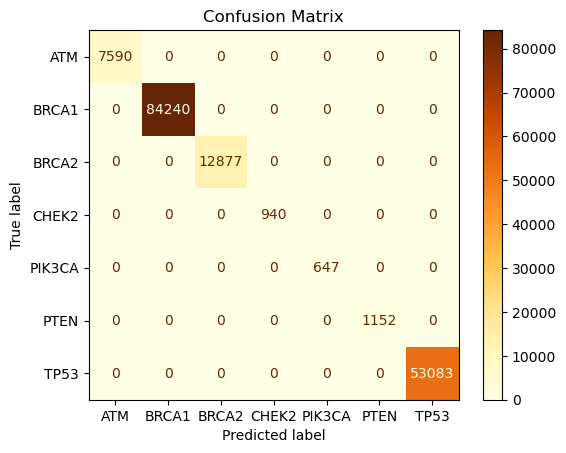

In [4]:
# Call the preprocess function
X, y, label_encoder = preprocess_data(df)


# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Identifying numerical and categorical features
numerical_features = ['chromosome', 'position']
categorical_features = [col for col in X.columns if col not in numerical_features]

# Normalizing the numerical data
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train[numerical_features])
X_test_num_scaled = scaler.transform(X_test[numerical_features])

# Creating DataFrames of the scaled data
X_train_scaled_df = pd.DataFrame(X_train_num_scaled, columns=numerical_features, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_num_scaled, columns=numerical_features, index=X_test.index)

# Recombining scaled numerical columns with categorical columns
X_train_final = pd.concat([X_train_scaled_df, X_train[categorical_features]], axis=1)
X_test_final = pd.concat([X_test_scaled_df, X_test[categorical_features]], axis=1)

# Building and training the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_final, y_train)

# Saving the trained model joblib and pickel
dump(model, 'randomforest_basic.joblib')

randomforest_basic = 'randomforest_basic.pkl'
with open(randomforest_basic, 'wb') as file:
    pickle.dump(model, file)

# Making predictions and evaluations
predictions = model.predict(X_test_final)


# Generating and displaying the classification report
print("Accuracy of Random Forest classifier on test set: {:.2f}".format(model.score(X_test_final, y_test)))
print(classification_report(y_test, predictions))

# Generating and displaying the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Visualizing the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.YlOrBr)
plt.title("Confusion Matrix")
plt.show()

GridSerach

In [5]:
# #1
# def stratified_sample(df, frac):
#     # Group by the 'Gene/Protein Symbol' column and apply sampling within each group
#     df_sample = df.groupby('Gene/Protein Symbol', group_keys=False).apply(lambda x: x.sample(frac=frac))
#     return df_sample



# df_sampled = stratified_sample(df, frac=0.2) 

In [6]:
# # Dropping 'Gene/Protein Symbol' column from df_sampled
# X = df_sampled.drop(columns=['Gene/Protein Symbol'])
# y = df_sampled['Gene/Protein Symbol']

# # Selecting only the specified categorical and numerical columns
# categorical_columns = ['class', 'most_severe_consequence', 'Category']
# numerical_columns = ['chromosome', 'position']

# # Encoding categorical columns
# encoder = OneHotEncoder(sparse_output=False, drop='first')
# encoded_categorical_data = encoder.fit_transform(X[categorical_columns])

# # Creating a new DataFrame with the encoded columns
# encoded_categorical_df = pd.DataFrame(encoded_categorical_data, columns=encoder.get_feature_names_out(categorical_columns))

# # Concatenating numerical and encoded data
# X_encoded = pd.concat([X[numerical_columns].reset_index(drop=True), encoded_categorical_df], axis=1)

# # Resetting indices to align X_encoded and y
# X_encoded.reset_index(drop=True, inplace=True)
# y.reset_index(drop=True, inplace=True)

# #Filtering the data to select only the 'XXXX' class
# X_class_0 = X_encoded[y == 'PIK3CA']
# y_class_0 = y[y == 'PIK3CA']

# # Selecting 20% of 'XXXX' class data for testing
# X_train_class_0, X_test_class_0, y_train_class_0, y_test_class_0 = train_test_split(X_class_0, y_class_0, test_size=0.2, random_state=42)

# # Defining the hyperparameter search space
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [4, 8, 12],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Creating a Random Forest classifier
# rfc = RandomForestClassifier(random_state=42)

# # Creating a GridSearchCV object
# grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy')

# # Fitting the grid search to the data
# grid_search.fit(X_train_class_0, y_train_class_0)

# # Obtaining the best model and parameters
# best_model = grid_search.best_estimator_
# best_params = grid_search.best_params_

# # Making predictions using the best model
# predictions = best_model.predict(X_test_class_0)

# # Evaluating the accuracy of the model on the test set
# accuracy = accuracy_score(y_test_class_0, predictions)
# print(f"Accuracy with best hyperparameters: {accuracy:.4f}")

# # Printing the best hyperparameters
# print("Best Hyperparameters:")
# for param_name, param_value in best_params.items():
#     print(f"\t{param_name}: {param_value}")

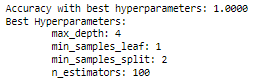

### class_weight=balanced

Class ATM: 0
Class BRCA1: 1
Class BRCA2: 2
Class CHEK2: 3
Class PIK3CA: 4
Class PTEN: 5
Class TP53: 6
Accuracy of Random Forest classifier on test set: 0.94
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      7590
           1       1.00      0.91      0.95     84240
           2       0.95      0.95      0.95     12877
           3       0.48      1.00      0.65       940
           4       1.00      1.00      1.00       647
           5       1.00      1.00      1.00      1152
           6       0.87      0.99      0.93     53083

    accuracy                           0.94    160529
   macro avg       0.89      0.97      0.92    160529
weighted avg       0.95      0.94      0.94    160529



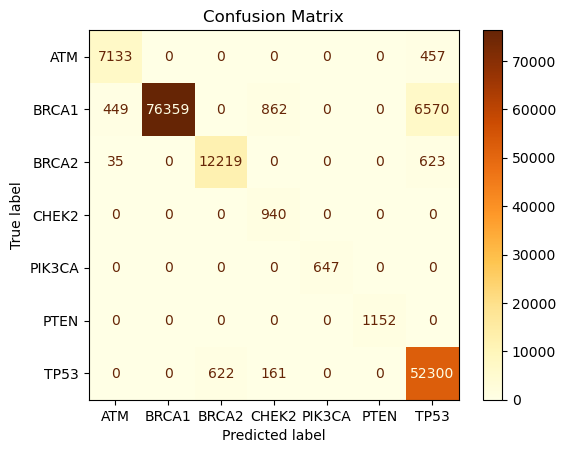

In [7]:
# Call the preprocess function
X, y, label_encoder = preprocess_data(df)

# Defyning X and y
X_res, y_res = X, y

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)

# Identifying numerical and categorical features
numerical_features = ['chromosome', 'position']
categorical_features = [col for col in X.columns if col not in numerical_features]

# Normalizing the numerical data
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train[numerical_features])
X_test_num_scaled = scaler.transform(X_test[numerical_features])

# Creating DataFrames of the scaled data
X_train_scaled_df = pd.DataFrame(X_train_num_scaled, columns=numerical_features, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_num_scaled, columns=numerical_features, index=X_test.index)

# Recombining scaled numerical columns with categorical columns
X_train_final = pd.concat([X_train_scaled_df, X_train[categorical_features]], axis=1)
X_test_final = pd.concat([X_test_scaled_df, X_test[categorical_features]], axis=1)

# Building and training the Random Forest model with constraints to avoid overfitting as per hyperparameter displayed on GridSearch
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,
    min_samples_split=2, 
    min_samples_leaf=1,
    random_state=42,
    class_weight="balanced"
)
rf_model.fit(X_train_final, y_train)

# Saving the trained model joblib and pickel
dump(rf_model, 'randomforest_class_weight_balanced.joblib')

randomforest_class_weight_balanced = 'randomforest_class_weight_balanced.pkl'
with open(randomforest_class_weight_balanced, 'wb') as file:
    pickle.dump(rf_model, file)

# Making predictions and evaluations
rf_predictions = rf_model.predict(X_test_final)

# Generating and displaying the classification report
print("Accuracy of Random Forest classifier on test set: {:.2f}".format(rf_model.score(X_test_final, y_test)))
print(classification_report(y_test, rf_predictions))

# Generating and displaying the confusion matrix
rf_cm = confusion_matrix(y_test, rf_predictions)

# Visualizing the confusion matrix with labels
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=label_encoder.classes_)
rf_disp.plot(cmap=plt.cm.YlOrBr)
plt.title("Confusion Matrix")
plt.show()


### Upsampling 7x with RandomOverSampler + class_weight=balanced

Class ATM: 0
Class BRCA1: 1
Class BRCA2: 2
Class CHEK2: 3
Class PIK3CA: 4
Class PTEN: 5
Class TP53: 6
Accuracy of Random Forest classifier on test set: 0.95
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7590
           1       1.00      0.91      0.95     84241
           2       1.00      0.95      0.97     12877
           3       0.91      1.00      0.95      6577
           4       1.00      1.00      1.00       647
           5       1.00      1.00      1.00      1152
           6       0.87      1.00      0.93     53083

    accuracy                           0.95    166167
   macro avg       0.96      0.97      0.97    166167
weighted avg       0.95      0.95      0.95    166167



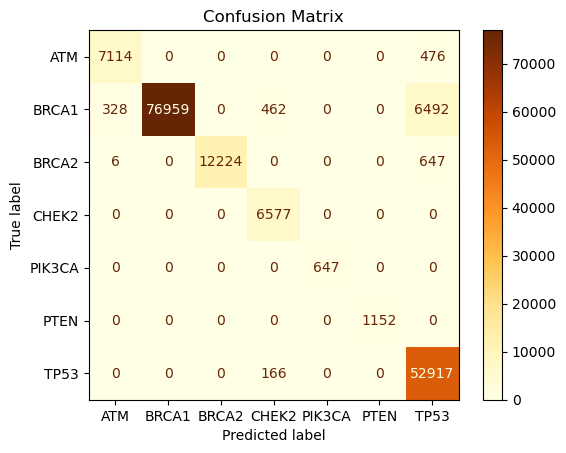

In [8]:
# Call the preprocess function
X, y, label_encoder = preprocess_data(df)


# Applying RandomOverSampler to balance class 3
ros = RandomOverSampler(sampling_strategy={3: y.value_counts()[3] * 7}, random_state=42)
X_res, y_res = ros.fit_resample(X, y)

# Splitting the balanced data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)

# Identifying numerical and categorical features
numerical_features = ['chromosome', 'position']
categorical_features = [col for col in X.columns if col not in numerical_features]

# Normalizing the numerical datas
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train[numerical_features])
X_test_num_scaled = scaler.transform(X_test[numerical_features])

# Creating DataFrames of the scaled data
X_train_scaled_df = pd.DataFrame(X_train_num_scaled, columns=numerical_features, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_num_scaled, columns=numerical_features, index=X_test.index)

# Recombining scaled numerical columns with categorical columns
X_train_final = pd.concat([X_train_scaled_df, X_train[categorical_features]], axis=1)
X_test_final = pd.concat([X_test_scaled_df, X_test[categorical_features]], axis=1)

# Building and training the Random Forest model with constraints to avoid overfitting as per hyperparameter displayed on GridSearch
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,
    min_samples_split=2, 
    min_samples_leaf=1,
    random_state=42,
    class_weight="balanced"
)
rf_model.fit(X_train_final, y_train)

# Saving the trained model joblib and pickel
dump(rf_model, 'randomforest_upsampling_class_weight_balanced.joblib')

randomforest_upsampling_class_weight_balanced = 'randomforest_upsampling_class_weight_balanced.pkl'
with open(randomforest_upsampling_class_weight_balanced, 'wb') as file:
    pickle.dump(rf_model, file)

# Making predictions and evaluations
rf_predictions = rf_model.predict(X_test_final)

# Generating and displaying the classification report
print("Accuracy of Random Forest classifier on test set: {:.2f}".format(rf_model.score(X_test_final, y_test)))
print(classification_report(y_test, rf_predictions))

# Generating and displaying the confusion matrix
rf_cm = confusion_matrix(y_test, rf_predictions)

# Visualizing the confusion matrix with labels
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=label_encoder.classes_)
rf_disp.plot(cmap=plt.cm.YlOrBr)
plt.title("Confusion Matrix")
plt.show()